# Comparison: Landsat area_km2 vs ndwi_area_km2

This notebook compares the two different calculation methods for Landsat data:
- **area_km2**: Standard optical method
- **ndwi_area_km2**: NDWI-based method

Analysis per location to identify differences and consistency between methods.

In [20]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported!")

Libraries imported!


In [22]:
# Load Landsat data only
db_path = r"sqlite:///db_1.db"
engine = create_engine(db_path, echo=False)

df = pd.read_sql("select * FROM water_surface_detection_v3 where sat_id != 'S1_GRD' and (error = 0 OR error_vis = 0) and ndwi_area_km2 is not null", con=engine)
df_landsat = df[df['sat_id'] != 'S1_GRD'].copy()

print(f"Total Landsat records: {len(df_landsat)}")
print(f"Unique locations: {df_landsat['loc'].nunique()}")
print(f"Satellite types: {df_landsat['sat_id'].unique()}")

# IMPORTANT: Filter for valid rows only (error=0 AND error_vis=0)
# This ensures we compare the SAME images with both methods
df_valid = df_landsat

print(f"\n{'='*80}")
print(f"FILTERED DATA (error=0 AND error_vis=0)")
print(f"{'='*80}")
print(f"Valid records for comparison: {len(df_valid)} ({len(df_valid)/len(df_landsat)*100:.1f}%)") 
print(f"Locations with valid data: {df_valid['loc'].nunique()}")
print(f"\nFiltering criteria:")
print(f"  - error = 0 (area_km2 method is valid)")
print(f"  - error_vis = 0 (ndwi_area_km2 method is valid)")
print(f"  - Both methods available for same image")
print(f"\nThis ensures we compare the EXACT same images with both methods!")

Total Landsat records: 47202
Unique locations: 76
Satellite types: ['LC08' 'LC09' 'LE07' 'LT05']

FILTERED DATA (error=0 AND error_vis=0)
Valid records for comparison: 47202 (100.0%)
Locations with valid data: 76

Filtering criteria:
  - error = 0 (area_km2 method is valid)
  - error_vis = 0 (ndwi_area_km2 method is valid)
  - Both methods available for same image

This ensures we compare the EXACT same images with both methods!


In [23]:
# Calculate differences and quality metrics
df_valid['difference'] = df_valid['area_km2'] - df_valid['ndwi_area_km2']
df_valid['abs_difference'] = np.abs(df_valid['difference'])
df_valid['ratio'] = df_valid['area_km2'] / df_valid['ndwi_area_km2'].replace(0, np.nan)
df_valid['percent_difference'] = (df_valid['difference'] / df_valid['ndwi_area_km2'].replace(0, np.nan)) * 100

# Calculate coefficient of variation (CV) for quality assessment per location
df_valid['area_km2_cv'] = df_valid.groupby('loc')['area_km2'].transform(lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan)
df_valid['ndwi_area_km2_cv'] = df_valid.groupby('loc')['ndwi_area_km2'].transform(lambda x: x.std() / x.mean() if x.mean() != 0 else np.nan)

print("="*80)
print("GLOBAL COMPARISON STATISTICS (Same Valid Images)")
print("="*80)
print(f"\narea_km2 statistics:")
print(df_valid['area_km2'].describe())

print(f"\nndwi_area_km2 statistics:")
print(df_valid['ndwi_area_km2'].describe())

print(f"\nDifference (area_km2 - ndwi_area_km2):")
print(df_valid['difference'].describe())

print(f"\nAbsolute Difference:")
print(df_valid['abs_difference'].describe())

print(f"\nPercent Difference:")
print(df_valid['percent_difference'].describe())

print(f"\nRatio (area_km2 / ndwi_area_km2):")
print(df_valid['ratio'].describe())

# Correlation
pearson_r, pearson_p = pearsonr(df_valid['area_km2'], df_valid['ndwi_area_km2'])
spearman_r, spearman_p = spearmanr(df_valid['area_km2'], df_valid['ndwi_area_km2'])

print(f"\nCorrelation between methods:")
print(f"  Pearson r: {pearson_r:.4f} (p-value: {pearson_p:.4e})")
print(f"  Spearman r: {spearman_r:.4f} (p-value: {spearman_p:.4e})")

# Agreement categories
threshold_5 = (df_valid['abs_difference'] <= df_valid['area_km2'] * 0.05).sum()
threshold_10 = (df_valid['abs_difference'] <= df_valid['area_km2'] * 0.10).sum()
threshold_20 = (df_valid['abs_difference'] <= df_valid['area_km2'] * 0.20).sum()

print(f"\nAgreement levels:")
print(f"  Within 5%: {threshold_5} ({threshold_5/len(df_valid)*100:.1f}%)")
print(f"  Within 10%: {threshold_10} ({threshold_10/len(df_valid)*100:.1f}%)")
print(f"  Within 20%: {threshold_20} ({threshold_20/len(df_valid)*100:.1f}%)")

# Quality comparison - Variability (CV)
print(f"\n{'='*80}")
print(f"QUALITY COMPARISON - Variability (Lower CV = Better)")
print(f"{'='*80}")
print(f"Mean CV for area_km2: {df_valid['area_km2_cv'].mean():.4f}")
print(f"Mean CV for ndwi_area_km2: {df_valid['ndwi_area_km2_cv'].mean():.4f}")
winner_cv = "area_km2" if df_valid['area_km2_cv'].mean() < df_valid['ndwi_area_km2_cv'].mean() else "ndwi_area_km2"
print(f"\nBetter quality (lower variability): {winner_cv}")

GLOBAL COMPARISON STATISTICS (Same Valid Images)

area_km2 statistics:
count    47202.000000
mean         6.356692
std         21.567390
min          0.000000
25%          0.047700
50%          0.345600
75%          2.227500
max        355.906800
Name: area_km2, dtype: float64

ndwi_area_km2 statistics:
count    47202.000000
mean         6.221253
std         21.500183
min          0.000000
25%          0.043200
50%          0.311400
75%          1.984950
max        425.150100
Name: ndwi_area_km2, dtype: float64

Difference (area_km2 - ndwi_area_km2):
count    47202.000000
mean         0.135439
std          4.301930
min       -227.133900
25%         -0.024300
50%          0.008100
75%          0.177300
max        155.358900
Name: difference, dtype: float64

Absolute Difference:
count    47202.000000
mean         0.936876
std          4.200856
min          0.000000
25%          0.013500
50%          0.083700
75%          0.552375
max        227.133900
Name: abs_difference, dtype: float64

In [24]:
# Per-location comparison with quality metrics
def compare_methods_by_location(df):
    comparison_metrics = []
    
    for loc in df['loc'].unique():
        loc_data = df[df['loc'] == loc]
        
        if len(loc_data) < 5:
            continue
        
        metrics = {
            'loc': loc,
            'n_records': len(loc_data),
            'area_km2_mean': loc_data['area_km2'].mean(),
            'area_km2_std': loc_data['area_km2'].std(),
            'area_km2_cv': loc_data['area_km2'].std() / loc_data['area_km2'].mean() if loc_data['area_km2'].mean() != 0 else np.nan,
            'ndwi_area_km2_mean': loc_data['ndwi_area_km2'].mean(),
            'ndwi_area_km2_std': loc_data['ndwi_area_km2'].std(),
            'ndwi_area_km2_cv': loc_data['ndwi_area_km2'].std() / loc_data['ndwi_area_km2'].mean() if loc_data['ndwi_area_km2'].mean() != 0 else np.nan,
            'mean_difference': loc_data['difference'].mean(),
            'mean_abs_difference': loc_data['abs_difference'].mean(),
            'median_difference': loc_data['difference'].median(),
            'std_difference': loc_data['difference'].std(),
            'mean_percent_diff': loc_data['percent_difference'].mean(),
            'median_percent_diff': loc_data['percent_difference'].median(),
        }
        
        # Determine better method by CV (lower is better)
        if pd.notna(metrics['area_km2_cv']) and pd.notna(metrics['ndwi_area_km2_cv']):
            if metrics['area_km2_cv'] < metrics['ndwi_area_km2_cv']:
                metrics['better_method'] = 'area_km2'
                metrics['cv_improvement'] = ((metrics['ndwi_area_km2_cv'] - metrics['area_km2_cv']) / metrics['ndwi_area_km2_cv']) * 100
            else:
                metrics['better_method'] = 'ndwi_area_km2'
                metrics['cv_improvement'] = ((metrics['area_km2_cv'] - metrics['ndwi_area_km2_cv']) / metrics['area_km2_cv']) * 100
        else:
            metrics['better_method'] = 'unknown'
            metrics['cv_improvement'] = np.nan
        
        # Correlation
        if loc_data['area_km2'].std() > 0 and loc_data['ndwi_area_km2'].std() > 0:
            metrics['pearson_r'], _ = pearsonr(loc_data['area_km2'], loc_data['ndwi_area_km2'])
        else:
            metrics['pearson_r'] = np.nan
        
        comparison_metrics.append(metrics)
    
    return pd.DataFrame(comparison_metrics)

comparison_report = compare_methods_by_location(df_valid)

print("="*80)
print("PER-LOCATION QUALITY COMPARISON")
print("="*80)

# Summary of better method
if 'better_method' in comparison_report.columns:
    method_counts = comparison_report['better_method'].value_counts()
    print(f"\nBetter method by location (based on lower CV):")
    for method, count in method_counts.items():
        print(f"  {method}: {count} locations ({count/len(comparison_report)*100:.1f}%)")

# Locations where area_km2 is better
area_better = comparison_report[comparison_report['better_method'] == 'area_km2'].sort_values('cv_improvement', ascending=False)
print(f"\n{'='*80}")
print(f"Locations where area_km2 is BETTER (n={len(area_better)}):")
print(f"{'='*80}")
print(area_better[['loc', 'n_records', 'area_km2_cv', 'ndwi_area_km2_cv', 'cv_improvement']].head(10))

# Locations where ndwi_area_km2 is better
ndwi_better = comparison_report[comparison_report['better_method'] == 'ndwi_area_km2'].sort_values('cv_improvement', ascending=False)
print(f"\n{'='*80}")
print(f"Locations where ndwi_area_km2 is BETTER (n={len(ndwi_better)}):")
print(f"{'='*80}")
print(ndwi_better[['loc', 'n_records', 'area_km2_cv', 'ndwi_area_km2_cv', 'cv_improvement']].head(10))

# Overall average CV comparison
print(f"\n{'='*80}")
print(f"OVERALL QUALITY WINNER")
print(f"{'='*80}")
mean_cv_area = comparison_report['area_km2_cv'].mean()
mean_cv_ndwi = comparison_report['ndwi_area_km2_cv'].mean()
print(f"Average CV across all locations:")
print(f"  area_km2: {mean_cv_area:.4f}")
print(f"  ndwi_area_km2: {mean_cv_ndwi:.4f}")
winner = "area_km2" if mean_cv_area < mean_cv_ndwi else "ndwi_area_km2"
improvement = abs(mean_cv_area - mean_cv_ndwi) / max(mean_cv_area, mean_cv_ndwi) * 100
print(f"\n  WINNER: {winner} (Better by {improvement:.1f}%)")

PER-LOCATION QUALITY COMPARISON

Better method by location (based on lower CV):
  ndwi_area_km2: 51 locations (67.1%)
  area_km2: 25 locations (32.9%)

Locations where area_km2 is BETTER (n=25):
     loc  n_records  area_km2_cv  ndwi_area_km2_cv  cv_improvement
16  1678         37     0.501635          1.414921       64.546753
33  2039        573     1.870354          4.635254       59.649366
11  1673        155     5.378005          9.259227       41.917346
3   1258        292     0.513559          0.874949       41.304156
7   1263        301     1.311446          2.215895       40.816420
6   1261        784     1.654840          2.776576       40.399995
69   706        550     0.011554          0.018283       36.805342
48   453        277     0.261254          0.366217       28.661413
71   708        477     1.037929          1.447187       28.279529
44   449        897     0.870439          1.209171       28.013585

Locations where ndwi_area_km2 is BETTER (n=51):
     loc  n_records

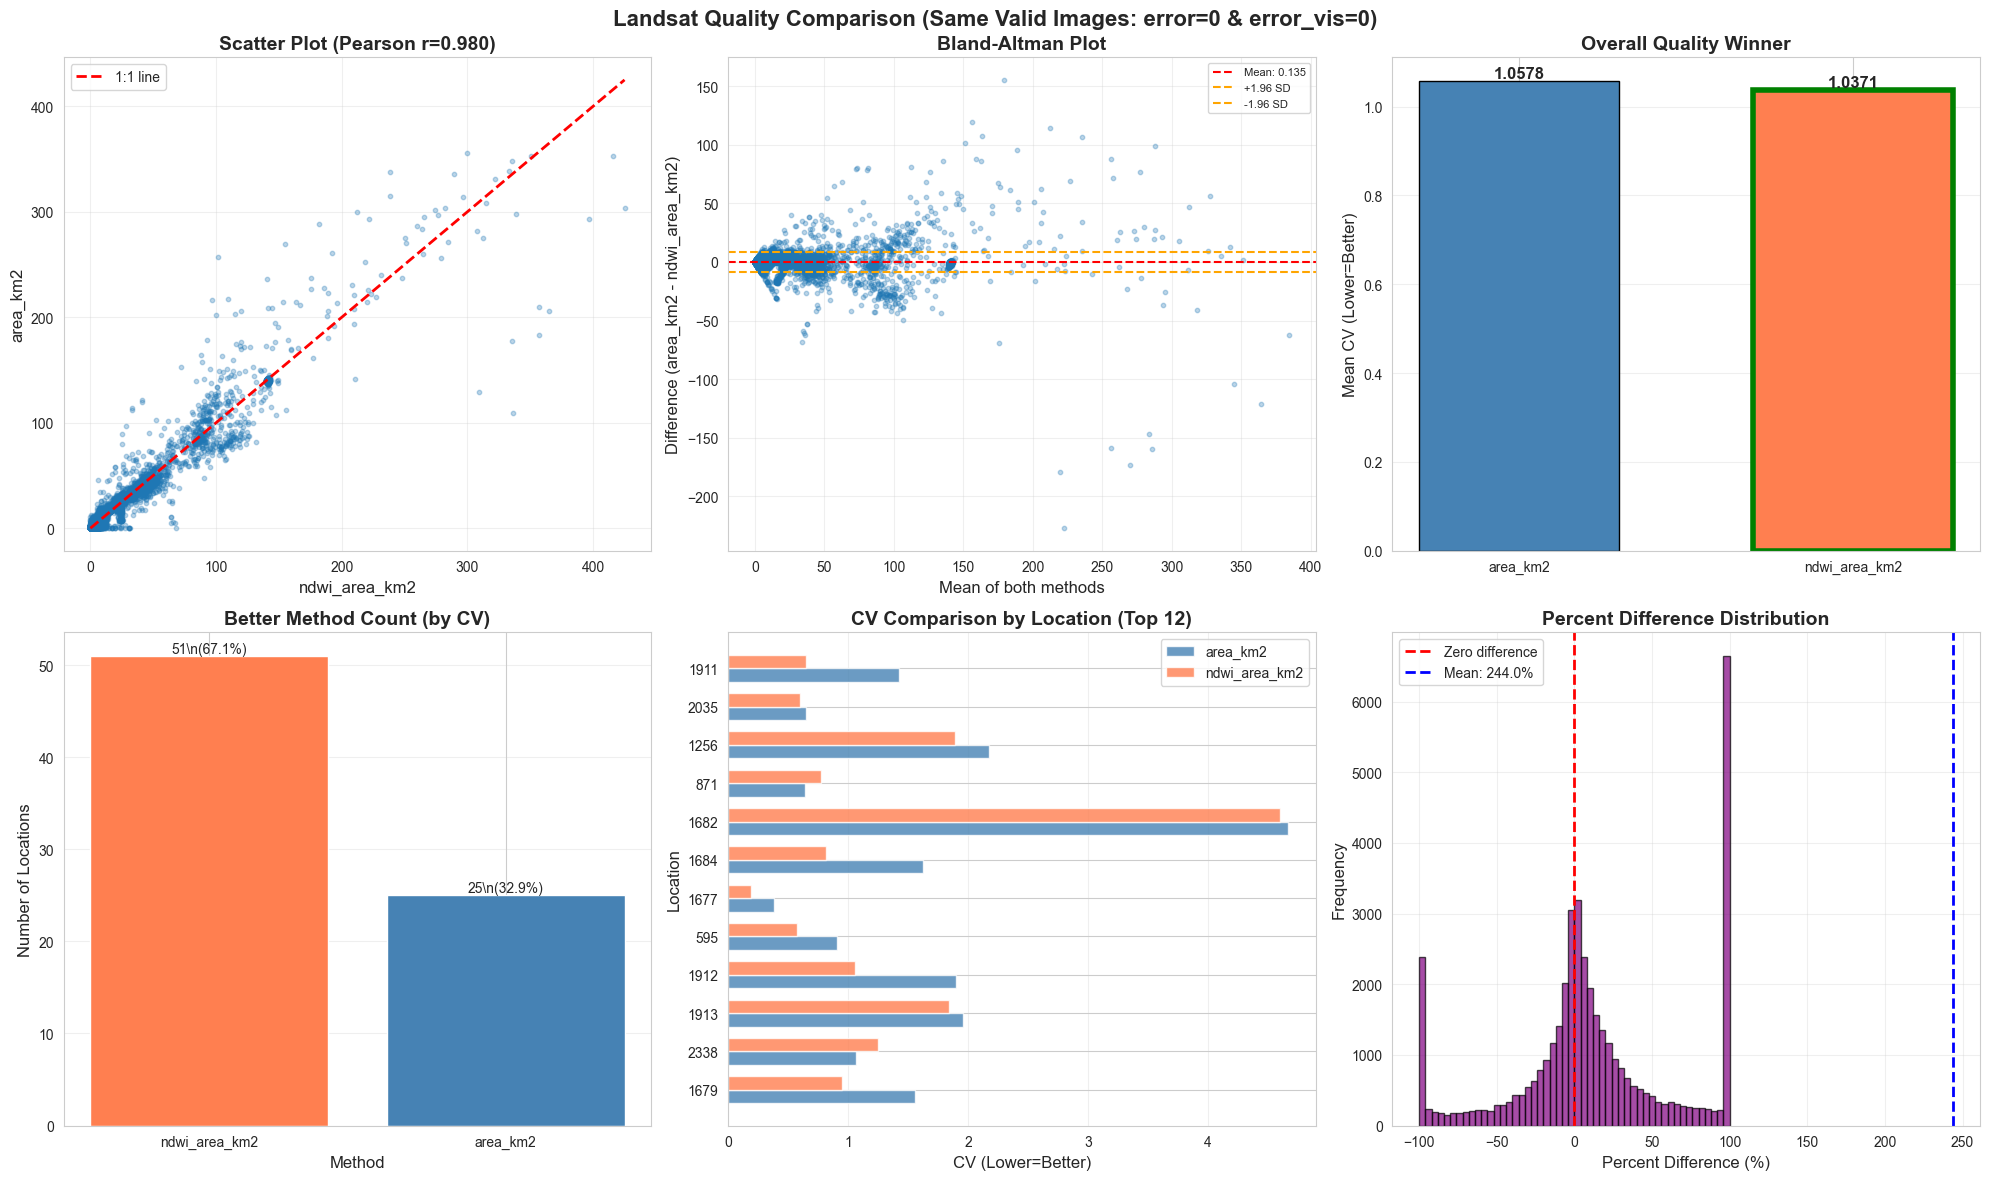

Visualizations created!


In [25]:
# Visualizations with quality focus
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Landsat Quality Comparison (Same Valid Images: error=0 & error_vis=0)', fontsize=16, fontweight='bold')

# 1. Scatter plot
ax1 = axes[0, 0]
ax1.scatter(df_valid['ndwi_area_km2'], df_valid['area_km2'], alpha=0.3, s=10)
max_val = max(df_valid['area_km2'].max(), df_valid['ndwi_area_km2'].max())
ax1.plot([0, max_val], [0, max_val], 'r--', label='1:1 line', linewidth=2)
ax1.set_xlabel('ndwi_area_km2', fontsize=12)
ax1.set_ylabel('area_km2', fontsize=12)
ax1.set_title(f'Scatter Plot (Pearson r={pearson_r:.3f})', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Bland-Altman plot
ax2 = axes[0, 1]
mean_vals = (df_valid['area_km2'] + df_valid['ndwi_area_km2']) / 2
ax2.scatter(mean_vals, df_valid['difference'], alpha=0.3, s=10)
ax2.axhline(df_valid['difference'].mean(), color='red', linestyle='--',
            label=f'Mean: {df_valid["difference"].mean():.3f}')
ax2.axhline(df_valid['difference'].mean() + 1.96*df_valid['difference'].std(), color='orange', linestyle='--', label='+1.96 SD')
ax2.axhline(df_valid['difference'].mean() - 1.96*df_valid['difference'].std(), color='orange', linestyle='--', label='-1.96 SD')
ax2.set_xlabel('Mean of both methods', fontsize=12)
ax2.set_ylabel('Difference (area_km2 - ndwi_area_km2)', fontsize=12)
ax2.set_title('Bland-Altman Plot', fontsize=14, fontweight='bold')
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Overall CV comparison
ax3 = axes[0, 2]
overall_cv = pd.DataFrame({
    'Method': ['area_km2', 'ndwi_area_km2'],
    'Mean CV': [comparison_report['area_km2_cv'].mean(), comparison_report['ndwi_area_km2_cv'].mean()]
})
bars = ax3.bar(overall_cv['Method'], overall_cv['Mean CV'], color=['steelblue', 'coral'], edgecolor='black', width=0.6)
ax3.set_ylabel('Mean CV (Lower=Better)', fontsize=12)
ax3.set_title('Overall Quality Winner', fontsize=14, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')
winner_idx = overall_cv['Mean CV'].idxmin()
bars[winner_idx].set_edgecolor('green')
bars[winner_idx].set_linewidth(4)
ax3.grid(True, alpha=0.3, axis='y')

# 4. Better method distribution
ax4 = axes[1, 0]
method_counts = comparison_report['better_method'].value_counts()
colors = {'area_km2': 'steelblue', 'ndwi_area_km2': 'coral', 'unknown': 'gray'}
bars = ax4.bar(method_counts.index, method_counts.values, color=[colors.get(m, 'gray') for m in method_counts.index])
ax4.set_xlabel('Method', fontsize=12)
ax4.set_ylabel('Number of Locations', fontsize=12)
ax4.set_title('Better Method Count (by CV)', fontsize=14, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\\n({height/len(comparison_report)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10)
ax4.grid(True, alpha=0.3, axis='y')

# 5. CV by location comparison
ax5 = axes[1, 1]
top_locs = comparison_report.nlargest(12, 'n_records')
x = np.arange(len(top_locs))
width = 0.35
ax5.barh(x - width/2, top_locs['area_km2_cv'], width, label='area_km2', alpha=0.8, color='steelblue')
ax5.barh(x + width/2, top_locs['ndwi_area_km2_cv'], width, label='ndwi_area_km2', alpha=0.8, color='coral')
ax5.set_yticks(x)
ax5.set_yticklabels(top_locs['loc'].astype(str))
ax5.set_xlabel('CV (Lower=Better)', fontsize=12)
ax5.set_ylabel('Location', fontsize=12)
ax5.set_title('CV Comparison by Location (Top 12)', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='x')

# 6. Percent difference distribution
ax6 = axes[1, 2]
ax6.hist(df_valid['percent_difference'].clip(-100, 100),
         bins=50, edgecolor='black', alpha=0.7, color='purple')

ax6.axvline(0, color='red', linestyle='--', linewidth=2,
            label='Zero difference')
ax6.axvline(df_valid['percent_difference'].mean(), color='blue',
            linestyle='--', linewidth=2,
            label=f'Mean: {df_valid["percent_difference"].mean():.1f}%')

ax6.set_xlabel('Percent Difference (%)', fontsize=12)
ax6.set_ylabel('Frequency', fontsize=12)
ax6.set_title('Percent Difference Distribution', fontsize=14, fontweight='bold')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualizations created!")


Analyzing location with largest mean difference: 1255

LOCATION 1255 - METHOD COMPARISON

Records: 378

area_km2 stats:
count    378.000000
mean       2.238148
std        0.761860
min        0.000000
25%        1.945125
50%        2.291400
75%        2.669850
max        3.914100
Name: area_km2, dtype: float64

ndwi_area_km2 stats:
count    378.000000
mean       1.976900
std        0.724468
min        0.000000
25%        1.694925
50%        2.066850
75%        2.291400
max        4.679100
Name: ndwi_area_km2, dtype: float64

Difference stats:
count    378.000000
mean       0.261248
std        0.370549
min       -2.741400
25%        0.142875
50%        0.239400
75%        0.351225
max        2.220300
Name: difference, dtype: float64

Correlation: r=0.8769, p=1.1415e-121


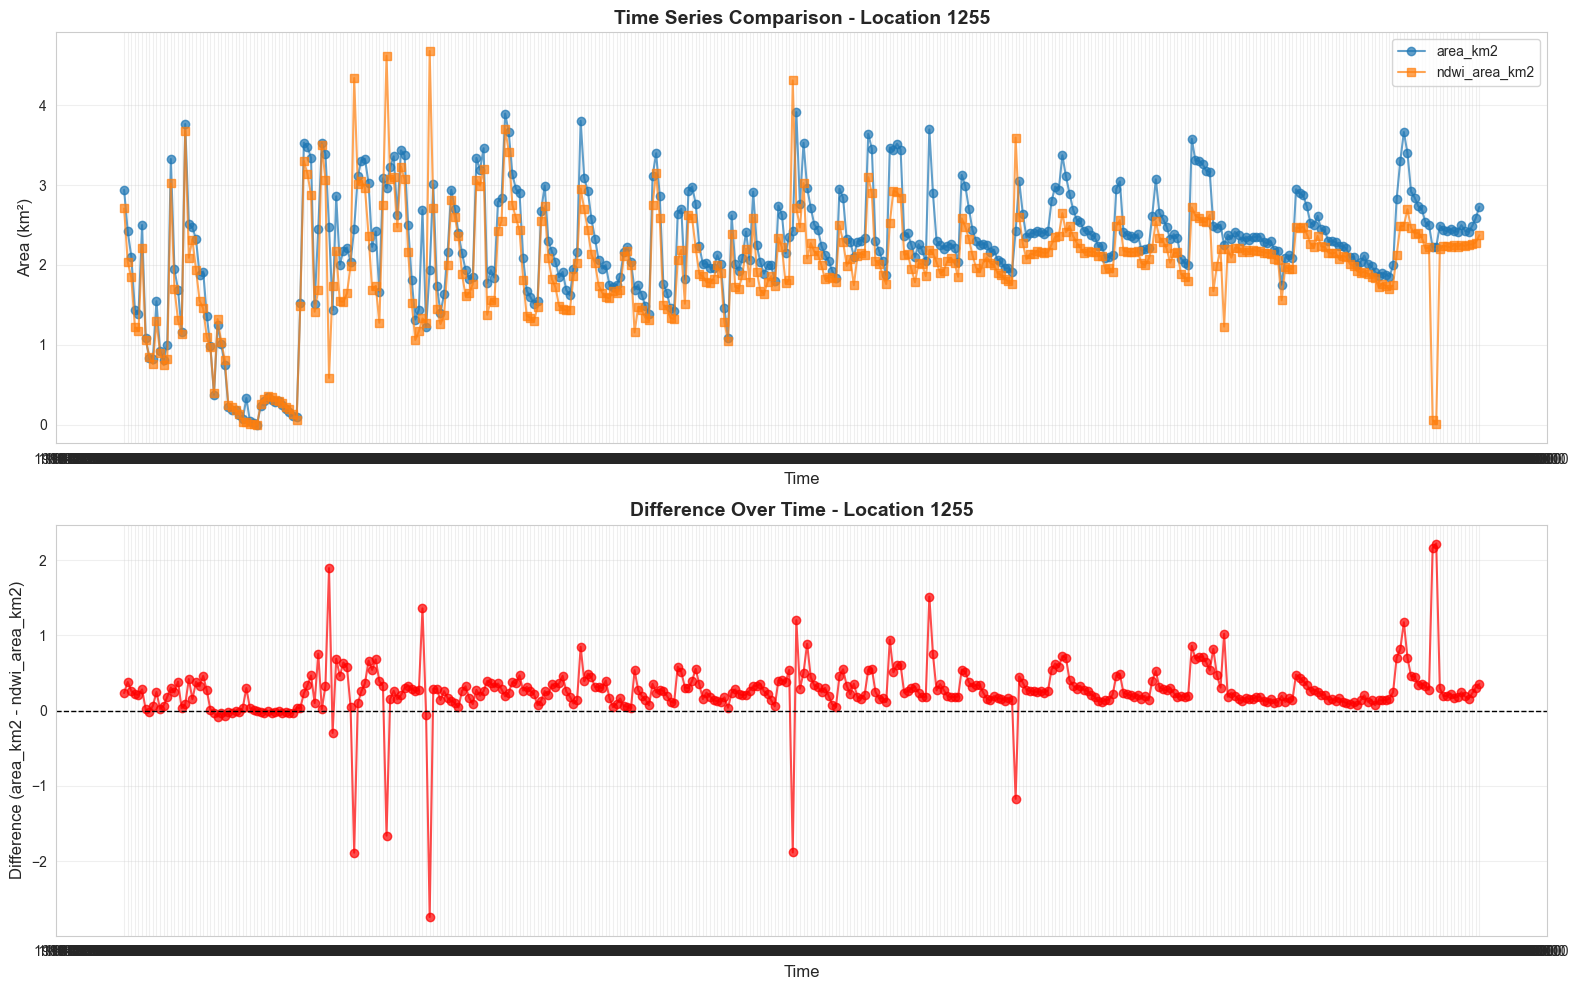

In [27]:
# Analyze specific location (example)
def analyze_location_comparison(df, loc_id):
    loc_data = df[df['loc'] == loc_id].copy()
    
    if len(loc_data) == 0:
        print(f"No data for location {loc_id}")
        return
    
    print("="*80)
    print(f"LOCATION {loc_id} - METHOD COMPARISON")
    print("="*80)
    
    print(f"\nRecords: {len(loc_data)}")
    print(f"\narea_km2 stats:")
    print(loc_data['area_km2'].describe())
    print(f"\nndwi_area_km2 stats:")
    print(loc_data['ndwi_area_km2'].describe())
    print(f"\nDifference stats:")
    print(loc_data['difference'].describe())
    
    if loc_data['area_km2'].std() > 0 and loc_data['ndwi_area_km2'].std() > 0:
        r, p = pearsonr(loc_data['area_km2'], loc_data['ndwi_area_km2'])
        print(f"\nCorrelation: r={r:.4f}, p={p:.4e}")
    
    # Time series comparison
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    ax1 = axes[0]
    loc_data_sorted = loc_data.sort_values('time')
    ax1.plot(loc_data_sorted['time'], loc_data_sorted['area_km2'], 'o-', label='area_km2', alpha=0.7)
    ax1.plot(loc_data_sorted['time'], loc_data_sorted['ndwi_area_km2'], 's-', label='ndwi_area_km2', alpha=0.7)
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('Area (km²)', fontsize=12)
    ax1.set_title(f'Time Series Comparison - Location {loc_id}', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[1]
    ax2.plot(loc_data_sorted['time'], loc_data_sorted['difference'], 'o-', color='red', alpha=0.7)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1)
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_ylabel('Difference (area_km2 - ndwi_area_km2)', fontsize=12)
    ax2.set_title(f'Difference Over Time - Location {loc_id}', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Analyze location with largest difference
if len(comparison_report) > 0:
    top_diff_loc = comparison_report.iloc[0]['loc']
    print(f"\nAnalyzing location with largest mean difference: {top_diff_loc}\n")
    analyze_location_comparison(df_valid, top_diff_loc)

In [28]:
# Export quality comparison results
print("="*80)
print("EXPORTING QUALITY COMPARISON RESULTS")
print("="*80)

# Full comparison data with quality metrics (only valid images)
export_cols = ['time', 'loc', 'image_id', 'sat_id', 'area_km2', 'ndwi_area_km2', 
               'difference', 'abs_difference', 'percent_difference', 'ratio']
df_valid[export_cols].to_csv('landsat_method_comparison_valid_only.csv', index=False)
print(f"Full comparison (valid images only): landsat_method_comparison_valid_only.csv ({len(df_valid)} records)")

# Per-location quality summary
comparison_report.to_csv('landsat_quality_comparison_by_location.csv', index=False)
print(f"Per-location quality summary: landsat_quality_comparison_by_location.csv ({len(comparison_report)} locations)")

# Locations where area_km2 is better
area_better.to_csv('locations_area_km2_is_better.csv', index=False)
print(f"Locations where area_km2 is better: locations_area_km2_is_better.csv ({len(area_better)} locations)")

# Locations where ndwi_area_km2 is better
ndwi_better.to_csv('locations_ndwi_area_km2_is_better.csv', index=False)
print(f"Locations where ndwi_area_km2 is better: locations_ndwi_area_km2_is_better.csv ({len(ndwi_better)} locations)")

# Large discrepancies (>20% difference)
large_discrepancies = df_valid[np.abs(df_valid['percent_difference']) > 20][export_cols]
large_discrepancies.to_csv('landsat_large_discrepancies_valid.csv', index=False)
print(f"Large discrepancies (>20%): landsat_large_discrepancies_valid.csv ({len(large_discrepancies)} records)")

# Summary report
with open('landsat_quality_comparison_summary.txt', 'w') as f:
    f.write("="*80 + "\\n")
    f.write("LANDSAT METHODS QUALITY COMPARISON SUMMARY\\n")
    f.write("="*80 + "\\n")
    f.write(f"\\nFiltering: error=0 AND error_vis=0 (same valid images)\\n")
    f.write(f"Valid records analyzed: {len(df_valid)}\\n")
    f.write(f"Locations analyzed: {df_valid['loc'].nunique()}\\n")
    f.write(f"\\nOVERALL QUALITY (Mean CV across locations):\\n")
    f.write(f"  area_km2: {comparison_report['area_km2_cv'].mean():.4f}\\n")
    f.write(f"  ndwi_area_km2: {comparison_report['ndwi_area_km2_cv'].mean():.4f}\\n")
    winner = "area_km2" if comparison_report['area_km2_cv'].mean() < comparison_report['ndwi_area_km2_cv'].mean() else "ndwi_area_km2"
    improvement = abs(comparison_report['area_km2_cv'].mean() - comparison_report['ndwi_area_km2_cv'].mean()) / max(comparison_report['area_km2_cv'].mean(), comparison_report['ndwi_area_km2_cv'].mean()) * 100
    f.write(f"  *** WINNER: {winner} (Better by {improvement:.1f}%) ***\\n")
    f.write(f"\\nLocations by better method:\\n")
    for method, count in comparison_report['better_method'].value_counts().items():
        f.write(f"  {method}: {count} ({count/len(comparison_report)*100:.1f}%)\\n")
    f.write(f"\\nCorrelation between methods:\\n")
    f.write(f"  Pearson r: {pearson_r:.4f}\\n")
    f.write(f"  Spearman r: {spearman_r:.4f}\\n")
    f.write(f"\\nAgreement levels:\\n")
    f.write(f"  Within 5%: {threshold_5} ({threshold_5/len(df_valid)*100:.1f}%)\\n")
    f.write(f"  Within 10%: {threshold_10} ({threshold_10/len(df_valid)*100:.1f}%)\\n")
    f.write(f"  Within 20%: {threshold_20} ({threshold_20/len(df_valid)*100:.1f}%)\\n")
    f.write(f"\\nINTERPRETATION:\\n")
    f.write(f"  CV < 0.3: Excellent consistency\\n")
    f.write(f"  CV 0.3-0.5: Good consistency\\n")
    f.write(f"  CV 0.5-1.0: Moderate consistency\\n")
    f.write(f"  CV > 1.0: High variability\\n")

print(f"Summary report: landsat_quality_comparison_summary.txt")
print("\\nAll quality comparison files exported successfully!")

EXPORTING QUALITY COMPARISON RESULTS
Full comparison (valid images only): landsat_method_comparison_valid_only.csv (47202 records)
Per-location quality summary: landsat_quality_comparison_by_location.csv (76 locations)
Locations where area_km2 is better: locations_area_km2_is_better.csv (25 locations)
Locations where ndwi_area_km2 is better: locations_ndwi_area_km2_is_better.csv (51 locations)
Large discrepancies (>20%): landsat_large_discrepancies_valid.csv (23468 records)
Summary report: landsat_quality_comparison_summary.txt
\nAll quality comparison files exported successfully!


# Summary

## Quality Comparison Methodology:

This analysis compares area_km2 vs ndwi_area_km2 using **only valid images** where:
- **error = 0** (area_km2 method succeeded)
- **error_vis = 0** (ndwi_area_km2 method succeeded)

This ensures we're comparing the **exact same images** with both methods.

## Quality Metric - Coefficient of Variation (CV):

**CV = Standard Deviation / Mean**

- **Lower CV = Better Quality** (more consistent/stable measurements)
- CV measures relative variability within each location
- Independent of scale/magnitude differences

## Key Results:

1. **Overall Winner**: Method with lower average CV across all locations
2. **Per-Location Winner**: Shows which method is more reliable for each specific location
3. **Correlation**: How well both methods agree (high correlation = consistent measurements)
4. **Agreement Levels**: Percentage of images within acceptable difference thresholds

## Interpretation Guide:

### CV Values:
- **CV < 0.3**: Excellent consistency ✓
- **CV 0.3-0.5**: Good consistency
- **CV 0.5-1.0**: Moderate consistency  
- **CV > 1.0**: High variability (quality concerns) ⚠

### Correlation:
- **r > 0.9**: Excellent agreement
- **r 0.7-0.9**: Good agreement
- **r < 0.7**: Weak agreement (investigate)

## Files Exported:

1. `landsat_quality_comparison_by_location.csv` - Complete quality metrics per location
2. `locations_area_km2_is_better.csv` - Locations where area_km2 wins
3. `locations_ndwi_area_km2_is_better.csv` - Locations where ndwi_area_km2 wins
4. `landsat_quality_comparison_summary.txt` - Overall summary with winner
5. `landsat_method_comparison_valid_only.csv` - Full comparison data
6. `landsat_large_discrepancies_valid.csv` - Cases with >20% difference

## Recommendation:

**Use the method with lower CV for your specific use case:**
- Check overall winner for global decision
- Use per-location winner for location-specific analysis
- Consider the winner has more stable and reliable measurements